In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import torch

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install wandb

In [ ]:
from torch_geometric.data import Data
from torch_geometric import utils
from torch_geometric.transforms import RandomLinkSplit
import torch_geometric as pyg
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from torch import nn
import torch.nn.functional as F
# import wandb
import networkx as nx
from pyvis.network import Network
from tqdm.auto import tqdm

In [ ]:
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df =pd.read_csv("/content/drive/MyDrive/Project/Data/SmallAmazonDataset.txt")
# dx=df[3:]
# # dx=dx.reset_index()
# dx = dx.drop(['index'], axis=1)

len = df.shape[0]


In [ ]:
from pandas.core.window.expanding import ExpandingIndexer
idx = 0
edge_index = []


in_degrees = np.zeros((1911, 1))
while idx < len:
    line = df.values[idx][0]


    start, end = line.strip().split()
    start, end = int(start), int(end)

    in_degrees[end][0] += 1

    edge_index.append([start, end])
    idx += 1

edge_index = torch.tensor(edge_index).t().contiguous()
graph = Data(x=in_degrees, edge_index=edge_index)


In [ ]:

print(graph)
print("Nodes: ",graph.num_nodes)


Data(x=[1911, 1], edge_index=[2, 1910])
Nodes:  1911


In [ ]:
from os import CLD_CONTINUED
#Visualize First 100
mask = np.zeros(graph.x.shape[0])
mask[:100] = 1
mask = torch.tensor(mask == 1)


# Create and save the new smaller graph by sampling nodes according to the a the mask
g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
netx = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
net = nx.Graph()

# Add the edges from the PyG graph to the PyVis network
for e in tqdm(g.edge_index.T):

    src = e[0].item()
    dst = e[1].item()
    if src == 0 or dst == 0:
        CLD_CONTINUED
    net.add_node(dst)
    net.add_node(src)
    net.add_edge(src, dst, value=0.1)
netx.from_nx(net)
netx.show("graph.html")


  0%|          | 0/352 [00:00<?, ?it/s]

In [ ]:
# Create a mask with the value True for nodes to be retained and False for nodes to be removed
# mask = np.zeros(g.x.shape[0])
# mask[:100] = 1
# mask = torch.tensor(mask == 1)
# for e in tqdm(g.edge_index.T):


#     src = e[0].item()
#     dst = e[1].item()
#     if src == 0 or dst == 0:
#         continue

  0%|          | 0/352 [00:00<?, ?it/s]

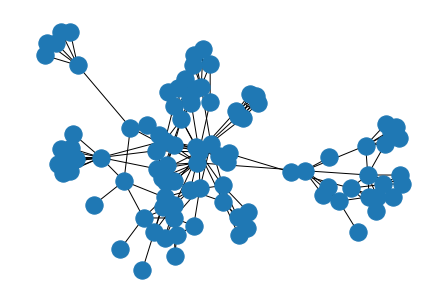

In [ ]:
net = nx.Graph()

for e in tqdm(g.edge_index.T):

    src = e[0].item()

    dst = e[1].item()

    if src == 0 or dst == 0:
        continue
    net.add_node(dst )
    net.add_node(src)
    net.add_edge(src, dst, value=0.1)
nx.draw(net)

In [ ]:
#LINK PREDICTION
transform = RandomLinkSplit(num_val=100, num_test=100, is_undirected=True, split_labels=True)
train_data, val_data, test_data = transform(graph)
print("Train Data",train_data)


print("Validation Data",val_data)
print("Test Data",test_data)

Train Data Data(x=[1911, 1], edge_index=[2, 1284], pos_edge_label=[642], pos_edge_label_index=[2, 642], neg_edge_label=[642], neg_edge_label_index=[2, 642])
Validation Data Data(x=[1911, 1], edge_index=[2, 1284], pos_edge_label=[100], pos_edge_label_index=[2, 100], neg_edge_label=[100], neg_edge_label_index=[2, 100])
Test Data Data(x=[1911, 1], edge_index=[2, 1484], pos_edge_label=[100], pos_edge_label_index=[2, 100], neg_edge_label=[100], neg_edge_label_index=[2, 100])


In [ ]:
import torch.nn as nn
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GNNStack , self).__init__()
        conv_model = pyg.nn.SAGEConv
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))


        # post-message-passing processing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))


    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)


        x = self.post_mp(x)


        # Return final layer of embeddings if specified
        return x


In [ ]:
# class GNN(torch.nn.Module):
#     def __init__(self,input_dim,hidden_channels , output_dim,  dropout):
#       super(Gnn).__init__()
#       self.conv1 = SAGEConv(input_dim, hidden_channels)
#       self.conv2 = SAGEConv(hidden_channels, hidden_channels)
#       self.conv3 = SAGEConv(hidden_channels, hidden_channels)


#       self.post_mp = nn.Sequential(
#           nn.Linear(hidden_channels,hidden_channels),nn.Dropout(self.dropout),
#           nn.Linear(hidden_channels, output_dim)
#       )



#     def forward(self, x,edge_index):
#         x = self.conv1(x,edge_index)
#         x = F.relu()
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.conv2(x,edge_index)
#         x = F.relu()
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.conv2(x,edge_index)
#         x = F.relu()
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.post_mp(x)
#         return x

In [ ]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

In [ ]:
a=[]
loss_list=[]
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
    global a, loss_list
    mod=model.train()
    lin=link_predictor.train()
    print(mod)
    print(lin)
    train_losses = []

    for edge_id in tqdm(pyg.loader.DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True), leave=True):
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                     num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        num = sum([1 for x in train_losses])
        loss_list.append(sum(train_losses)/num)

    return train_losses

In [ ]:
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# gpu_usage()




In [ ]:
import matplotlib.pyplot as plt
train_graph = train_data
val_graph = val_data



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 400
hidden_dim = 256
dropout = 0.3
num_layers = 6
lr = 1e-5
node_emb_dim = 1
batch_size = 256


train_graph = train_graph.to(device)
val_graph = val_graph.to(device)




model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)


optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()),
    lr=lr, weight_decay=optim_wd
)

# x=[]
# y=[]

# print(train_graph.edge_index)
# for epoch in range(100):
train_loss = train(model, link_predictor, torch.tensor(train_graph.x).float().to(device), train_graph.edge_index, train_graph.pos_edge_label_index.T, batch_size, optimizer)

num = sum([1 for x in train_loss])
train_lossess = sum(train_loss)/num
train_lossess
# 		print(train_loss)

# 		x.append(train_loss[0])
# 		y.append(train_loss[1])
# 		train_loss[0],train_loss[1]
# print(x),print(y)
# plt.plot(x, y)
# plt.show()
# gpu_usage()


GNNStack(
  (convs): ModuleList(
    (0): SAGEConv(1, 256, aggr=mean)
    (1): SAGEConv(256, 256, aggr=mean)
    (2): SAGEConv(256, 256, aggr=mean)
    (3): SAGEConv(256, 256, aggr=mean)
    (4): SAGEConv(256, 256, aggr=mean)
    (5): SAGEConv(256, 256, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)
LinkPredictor(
  (lins): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


  0%|          | 0/3 [00:00<?, ?it/s]

1.386631687482198

In [ ]:
train_loss

[1.3862192630767822, 1.386811375617981, 1.386864423751831]

In [ ]:
edge_index.shape

torch.Size([2, 1910])

In [ ]:
a

[]

In [ ]:

# mask = np.zeros(graph.x.shape[0])
# mask[100:150] = 1
# mask = torch.tensor(mask == 1)
# g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
# g.edge_index = g.edge_index - 100


# model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
# link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

# print(type(torch.tensor(g.x).cuda()))
# print(type(torch.tensor(g.edge_index).contiguous().cuda()))
# node_emb = model(torch.tensor(g.x).cuda(), torch.tensor(g.edge_index).contiguous().cuda())



In [ ]:
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

In [ ]:
# wandb.init(project="gnn-recommender", job_type="preprocessing", save_code=True)
# file_path = wandb.use_artifact("manan-goel/gnn-recommender/raw-data:v0").download()

In [ ]:
# wandb.init(project="gnn-recommender", job_type="preprocessing", save_code=True)
# file_path = wandb.use_artifact("manan-goel/gnn-recommender/raw-data:v0").download()
# # with open(f'{file_path}/amazon0302.txt', 'r') as f:
# #     edges = f.readlines()
# #     print(edges)
# #     idx = 0
# #     edge_index = []
# #     in_degrees = np.zeros((262111, 1))

# #     while (idx) < len(edges):
# #         print(f"{idx}/{len(edges)}", end='\r')
# #         line = edges[idx]
# #         if line.startswith('#'):
# #             idx += 1
# #             continue
# #         start, end = line.strip().split()
# #         start, end = int(start), int(end)
# #         in_degrees[end][0] += 1

# #         edge_index.append([start, end])
# #         idx += 1

# #     edge_index = torch.tensor(edge_index).t().contiguous()
# #     graph = Data(x=in_degrees, edge_index=edge_index)

# graph_artifact = wandb.Artifact('amazon_product_graph', type='graph')
# torch.save(graph, 'amazon0302.pt')
# graph_artifact.add_file('amazon0302.pt')
# wandb.log_artifact(graph_artifact)
# wandb.finish()


In [ ]:
# import torch
# import numpy as np
# from torch_geometric.data import Data
# from torch_geometric import utils
# import wandb
# from torch import nn
# import torch_geometric as pyg
# from torch.nn import functional as F
# from tqdm.auto import trange
# import pickle
# from pyvis.network import Network




# # with open('./metadata.pkl', 'rb') as f:
# #     metadata = pickle.load(f)


# graph = torch.load('amazon0302.pt')
# mask = np.zeros(graph.x.shape[0])
# mask[50000:55000] = 1
# mask = torch.tensor(mask == 1)


# g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
# g.edge_index = g.edge_index - 50000


# wandb.init(project='gnn-recommender', job_type='test')
# model_dir = wandb.use_artifact('manan-goel/gnn-recommender/gnn-model-sentence-transformer:latest').download()
# run = wandb.Api().run("manan-goel/gnn-recommender/3ca5rr0e")


# device = torch.device("cuda:0")
# optim_wd = run.config['optim_wd']
# epochs = run.config['epochs']
# hidden_dim = run.config['hidden_dim']
# dropout = run.config['dropout']
# num_layers = run.config['num_layers']
# lr = run.config['lr']
# node_emb_dim = run.config['node_embedding_dim']
# batch_size = run.config['batch_size']


# model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
# link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)


# model.load_state_dict(torch.load(f'{model_dir}/graph_embeddings.tar'))
# link_predictor.load_state_dict(torch.load(f'{model_dir}/link_predictor.tar'))


# node_emb = model(torch.tensor(g.x).cuda(), torch.tensor(g.edge_index).contiguous().cuda())
# act_conn = []


# for i in trange(10):
#     conn = []
#     for j in trange(5000):
#         if i == j:
#             continue
#         prob = link_predictor(node_emb[i], node_emb[j]).item()
#         if prob > 0.9:
#             conn.append([prob, 50000 + i, 50000 + j])
#     conn.sort(key=lambda x: x[0])
#     act_conn.extend(conn[:5])


# net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
# for e in act_conn:
#     src = e[1]
#     # dst = e[2]

#     # src_title = "Title:" + metadata[src]['title'] + "\n\n" + "Categories:\n" + "\n".join(list(metadata[src]['categories'])[:3])
#     # dst_title = "Title:" + metadata[dst]['title'] + "\n\n" + "Categories:\n" + "\n".join(list(metadata[dst]['categories'])[:3])

#     # net.add_node(dst, label=dst_title, title=dst_title)
#     # net.add_node(src, label=src_title, title=src_title)
#     net.add_edge(src, dst, value=e[0])


# net.show('net.html')
# wandb.log({'test/graph': wandb.Html('net.html')})
# wandb.finish()


run = wandb.Api().run("manan-goel/gnn-recommender/3ca5rr0e")

In [ ]:
from tqdm.auto import trange
mask = np.zeros(graph.x.shape[0])
mask[50000:55000] = 1
mask = torch.tensor(mask == 1)



g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
g.edge_index = g.edge_index - 50000




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 300
hidden_dim = 1024
dropout = 0.3
num_layers = 2
lr = 1e-5
node_emb_dim = 1
batch_size = 1024
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)


# model.load_state_dict(torch.load(f'{model_dir}/graph_embeddings.tar'))
# link_predictor.load_state_dict(torch.load(f'{model_dir}/link_predictor.tar'))


node_emb = model(torch.tensor(g.x).cuda(), torch.tensor(g.edge_index).contiguous().device())
act_conn = []


for i in trange(10):
    conn = []
    for j in trange(5000):
        if i == j:
            continue
        prob = link_predictor(node_emb[i], node_emb[j]).item()
        if prob > 0.9:
            conn.append([prob, 50000 + i, 50000 + j])
    conn.sort(key=lambda x: x[0])
    act_conn.extend(conn[:5])


net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
for e in act_conn:
    src = e[1]
    dst = e[2]

    net.add_node(dst)
    net.add_node(src)
    net.add_edge(src, dst, value=e[0])


net.show('net.html')
wandb.log({'test/graph': wandb.Html('net.html')})
wandb.finish()


RuntimeError: ignored